In [31]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import pickle
from copy import deepcopy
from ortools.linear_solver import pywraplp
import networkx as nx

import os, sys
import json
import datetime

# Definitions and Data Loading

In [32]:
input_path = 'data'

In [33]:
# Time that is added to the latency each time it reaches a node that is not the target (servisers node)
HOP_TIME_MS = 50.  # [ms]
LATENCY_METRIC = 'median_success_latency' # 'weighted_success_latency'

In [34]:
# Read cloud ping data
columns_ping_data = np.genfromtxt(os.path.join(input_path, 'cloudping_p50_1W_02-02-2023.csv'), delimiter=",", usecols=(0), dtype=str)
columns_ping_data = [a.split(' ')[-1] for a in columns_ping_data]
ping_data = np.genfromtxt(os.path.join(input_path, 'cloudping_p50_1W_02-02-2023.csv'), delimiter=",")[:,1:]
# Create dictionaries for column to index conversion
loc_ping_dict = { i : a for a, i in enumerate(columns_ping_data)}
loc_ping_dict_inv = { a : i for a, i in enumerate(columns_ping_data)}

In [35]:
# Read historical latency data by gateway
data_df = pd.read_csv(os.path.join(input_path, 'historical_data.csv'), index_col=0)
data_df['date'] = data_df['date'].map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

# Pre Process Data

In [36]:
# Average historical data over the observed period
grouped_df = data_df.groupby('gateway').agg({'median_success_latency' : "mean", 
                                             'weighted_success_latency' : "mean", 
                                             'p_90_latency' : "mean", 
                                             'success_rate' : "mean",  
                                             'total_success' : "sum"}).reset_index()
grouped_df

,gateway,median_success_latency,weighted_success_latency,p_90_latency,success_rate,total_success
0,ap-east-1,0.163512,0.229177,0.241171,0.991958,3075791944
1,ap-northeast-1,0.534434,0.778632,0.855377,0.955993,4246159791
2,ap-northeast-2,0.322403,0.403431,0.445752,0.993367,3225781873
3,ap-south-1,0.295218,0.376591,0.427422,0.994029,407696173
4,ap-southeast-1,0.075212,0.108063,0.118408,0.993959,11016826483
5,ca-central-1,0.185682,0.238066,0.266844,0.996725,521897913
6,eu-central-1,0.081806,0.123698,0.150011,0.993848,13848272493
7,eu-north-1,0.161218,0.231729,0.262870,0.994851,2015247834
8,eu-south-1,0.152917,0.212740,0.260691,0.993368,943586648
9,eu-west-1,0.234468,0.273765,0.330305,0.997189,162269559


In [37]:
# Calculate the average latency of the current deployment
current_avg_latency = ((grouped_df[LATENCY_METRIC]*grouped_df['total_success']).sum()/grouped_df['total_success'].sum())*1000.
print('Current average latency: %0.2f ms'%current_avg_latency)


Current average latency: 155.66 ms


### Construct Problem DataFrame

In [38]:
def create_data(ping_data, ping_data_columns, grouped_df, latency_metric):
    gateways_list = list()
    relays = list()
    latency = list()
    for i, g_i in enumerate(ping_data_columns):
      j_list = list()
      for j, g_j in enumerate(ping_data_columns):
        if g_i in grouped_df["gateway"].unique() and g_j in grouped_df["gateway"].unique():
          j_list.append(ping_data[j,i])
      if g_i in grouped_df["gateway"].unique():
        gateways_list.append(g_i)
        # relays originated in g_i
        relays.append(grouped_df.loc[grouped_df["gateway"]==g_i,"total_success"].values[0])
        # latency from g_i to servicer (in s)
        j_list.append(grouped_df.loc[grouped_df["gateway"]==g_i,latency_metric].values[0]*1000)
        latency.append(j_list)
    
    # add fictionary servicer latency
    latency.append(len(j_list)*[20000])
    data = dict()
    
    data["gateway"] = gateways_list
    data["relays"] = relays
    data["latency"] = latency
    return data


In [39]:
data = create_data(ping_data, columns_ping_data, grouped_df, LATENCY_METRIC)


# Define Problem

### Sets
$$
\begin{array}{ll}
  V & \text{Set of nodes (with out servicer)}, V=\{1,...,n-1\} \\
  V^\prime & \text{Set of nodes + Service}r, V^{\prime}= \{ V \cup  n \}  \\ 
  A & \text{Set of arcs}, A= \{ (j,k )\: \: j,k\in V^\prime, j\neq k \}  \\
\end{array}\\  
$$

### Parameters
$$
\begin{array}{ll}
  n & \text{Number of nodes + Servicer}\\
  M & \text{Big value}\\
  d_i & \text{node demand (relays) } i\in V^{\prime}; d_n=0\\
  c_{jk} & \text{Travel time between nodes j and k}\\
  q & \text{max number of active arcs to node Servicer}\\
  p & \text{Hop penalization}\\
\end{array}\\  
$$

In [40]:
# Parameters
n = len(data["gateway"]) + 1
maxArcs = 15
M = 300000000000
p = HOP_TIME_MS # hop penalization
d = data["relays"]
c = data["latency"]

### Desition variables
$$
\begin{array}{ll}
x^{i}_{jk}& \text{1 if the relays/demand originated in } i \text{ pass trough arc } j  \text{to arc } k, 0 \text{ if not} \\
y_{j}& 1 \text{ if the server } n \text{ is reached from } j, 0 \text{ otherwise}\\
\end{array}
$$

In [41]:
# Create the mip solver with the SCIP backend.
solver = pywraplp.Solver.CreateSolver("SCIP")
if not solver:
  raise Exception("Could not create solver")  

In [42]:
# ----------------------------------------------------------
# Variables
# ----------------------------------------------------------
# x[i, j, k] = 1 if for the route i the arc (j,k) is active.
# dvar boolean x[1..n][1..n][1..n];
x = {}
for i in range(n-1): # route
    for j in range(n): # arc_i
        for k in range(n): # arc_k
            x[(i, j, k)] = solver.IntVar(0, 1, "x_%i_%i_%i" % (i, j, k))

# dvar boolean y[1..n];
# # y[j] = 1 if the bin j gateway is connected to servicer
y = {}
for j in range(n):
    y[j] = solver.IntVar(0, 1, "y_%i" % j)

### Constrains

$$
\begin{equation*}
	\begin{align}
		\sum_{k \in V^{\prime}; k\neq i } x^{i}_{ik} - \sum_{k \in V^{\prime}; k\neq i } x^{i}_{ki} = 1 & \quad \forall i\in V \\
		\sum_{k \in V} x^{i}_{nk} - \sum_{k \in V} x^{i}_{kn} = -1 & \quad \forall i\in V \\
		\sum_{k \in V^{\prime}; k\neq j} x^{i}_{jk} = \sum_{k \in V^{\prime}; k\neq j} x^{i}_{kj} & \quad \forall i\in V; j\in V \\
		\sum_{k \in V^{\prime}} x^{i}_{jk} \leq 1 & \quad \forall i\in V; j\in V^{\prime} \\
		\sum_{i \in V} x^{i}_{jn} \leq My_j & \quad \forall j\in V \\
		\sum_{i \in V} x^{i}_{jn} \geq y_j & \quad \forall j\in V \\
		\sum_{j \in V} y_j \leq q \\
		x^{i}_{jk}, y_j \in \left\lbrace 0,1 \right\rbrace  & \quad i \in V; j\in V^{\prime};k\in V^{\prime} \\
	\end{align}
\end{equation*}
$$

* Constraints 1 says that the sum of the arcs that leave node $i$ minus the sum of the arcs that arrive at node $i$ must be $1$; This guarantees that from node $i$, being this the initial node of the path, $1$ comes out only arc, for the route $i$.

* Constraint 2 says that the sum of the arcs leaving the server $n$ minus the sum of the arcs arriving at the server $n$ must be $-1$; this guarantees that from the server, since this is the end of the path, only $1$ arc arrives for route $i$.

* Restrictions 3 says that for each route $i$ the number of arcs that arrive at node $j$ must be equal to the number of arcs that leave node $j$.

* Restrictions 4 prevent a node $j$ from being visited more than once in the same route $i$.

* Constraints 5 and 6 relate the variables $x$ and $y$. If the sum of arcs leaving node $j$ towards the server is $0$; then $y_j=0$. Conversely, if the sum of the arcs leaving node $j$ towards the server is greater than or equal to $1$, $y_j=1$.

* Constraints 7 guarantees that the number of arcs arriving at the server is less than or equal to $q$.

* Constraints 8 establish the nature of the variables.


In [43]:
# ----------------------------------------------------------
# Constraints
# ----------------------------------------------------------

# 1)
# forall (i in 1..n-1) sum(k in 1..n : i!=k) x[i][i][k] - sum(k in 1..n : i!=k) x[i][k][i] == 1;
for i in range(n-1):
    solver.Add(
      solver.Sum([x[(i, i, k)] for k in range(n) if i != k]) - \
      solver.Sum([x[(i, k, i)] for k in range(n) if i != k]) == 1)

In [44]:
# 2)
# forall (i in 1..n-1) sum(k in 1..n-1) x[i][n][k] - sum(k in 1..n-1) x[i][k][n] == -1;
for i in range(n-1):
    solver.Add(
      solver.Sum([x[(i, n-1, k)] for k in range(n-1)]) - \
      solver.Sum([x[(i, k, n-1)] for k in range(n-1)]) == -1)

In [45]:
# 3)
# forall (i in 1..n-1, j in 1..n-1 : i!=j) sum(k in 1..n : j!=k) x[i][j][k] == sum(k in 1..n : j!=k) x[i][k][j];
for i in range(n-1):
    for j in range(n-1):
        if i != j:
            solver.Add(
              solver.Sum([x[(i, j, k)] for k in range(n) if j != k]) == \
              solver.Sum([x[(i, k, j)] for k in range(n) if j != k]))

In [46]:
# 4)
# forall (i in 1..n-1, j in 1..n) sum(k in 1..n) x[i][j][k] <= 1;
for i in range(n-1):
    for j in range(n):
        solver.Add(
          solver.Sum([x[(i, j, k)] for k in range(n)]) <= 1)

In [47]:
# 5)
# forall (j in 1..n-1) sum(i in 1..n-1) x[i][j][n] <= M*y[j];
for j in range(n-1):
    solver.Add(
      solver.Sum([x[(i, j, n-1)] for i in range(n-1)]) <= M*y[j])

In [48]:
# 6)
# forall (j in 1..n-1) sum(i in 1..n-1) x[i][j][n] >= y[j];
for j in range(n-1):
    solver.Add(
      solver.Sum([x[(i, j, n-1)] for i in range(n-1)]) >= y[j])
      

In [49]:
# 7)
# sum (j in 1..n-1) y[j] <= maxArcs;
solver.Add(
  solver.Sum([y[j] for j in range(n-1)]) <= maxArcs)

<ortools.linear_solver.pywraplp.Constraint; proxy of <Swig Object of type 'operations_research::MPConstraint *' at 0x7fd4ab837930> >

### Objective
$$
\begin{equation*}
	\begin{gather}
		\text{Min} \quad \sum_{i \in V} \sum_{j \in V} \sum_{k \in V^{\prime}; k\neq j} d_i c_{jk} x^{i}_{jk}  + \sum_{i \in V} \sum_{j \in V} \sum_{k \in V; k\neq j}d_i p x^{i}_{jk}  \nonumber\\
	\end{gather}
\end{equation*}\\
$$

In [50]:
# ----------------------------------------------------------
# Objective:
# ----------------------------------------------------------
# z == sum(i in 1..n-1, j in 1..n-1, k in 1..n : j!=k) d[i]*c[j][k]*x[i][j][k] + sum(i in 1..n-1, j in 1..n-1, k in 1..n : j!=k) d[i]*p*x[i][j][k];
z = solver.Sum(
  solver.Sum(
    solver.Sum(
      d[i]*c[j][k]*x[(i, j, k)] for k in range(n) if j != k) for j in range(n)) for i in range(n-1)) + \
  solver.Sum(
    solver.Sum(
      solver.Sum(
        d[i]*p*x[(i, j, k)] for k in range(n-1) if j != k) for j in range(n)) for i in range(n-1))

# Run Solution

In [51]:
# solver minimizer
solver.Minimize(z)
# status solver
status = solver.Solve()

In [52]:
if status == pywraplp.Solver.OPTIMAL:
    print("Solution: OPTIMAL, Time = ", solver.WallTime(), " milliseconds")
    print("Objective value = ", solver.Objective().Value())
    print("Number of variables = ", solver.NumVariables())
    print("Number of constraints = ", solver.NumConstraints())
    print("Number of branch-and-bound nodes explored = ", solver.nodes())
    print("Number of simplex iterations = ", solver.iterations())
    print("Number of branch-and-bound nodes explored = ", solver.nodes())

    for i in range(n-1):
        for j in range(n):
            for k in range(n):
                if x[(i, j, k)].solution_value() > 0.5:
                    print("x[%i][%i][%i] = %i" % (i, j, k, x[(i, j, k)].solution_value()))

Solution: OPTIMAL, Time =  1439  milliseconds
Objective value =  6236596795111.662
Number of variables =  3856
Number of constraints =  511
Number of branch-and-bound nodes explored =  1
Number of simplex iterations =  64
Number of branch-and-bound nodes explored =  1
x[0][0][4] = 1
x[0][4][15] = 1
x[1][1][4] = 1
x[1][4][15] = 1
x[2][2][4] = 1
x[2][4][15] = 1
x[3][3][4] = 1
x[3][4][15] = 1
x[4][4][15] = 1
x[5][5][12] = 1
x[5][12][15] = 1
x[6][6][15] = 1
x[7][6][15] = 1
x[7][7][6] = 1
x[8][6][15] = 1
x[8][8][6] = 1
x[9][6][15] = 1
x[9][9][6] = 1
x[10][10][15] = 1
x[11][11][15] = 1
x[12][12][15] = 1
x[13][13][15] = 1
x[14][14][15] = 1


In [53]:

optimal_latency = solver.Objective().Value()/grouped_df['total_success'].sum()
print('Optimal solution latency : %0.2f'%optimal_latency)


Optimal solution latency : 118.76


### Plots

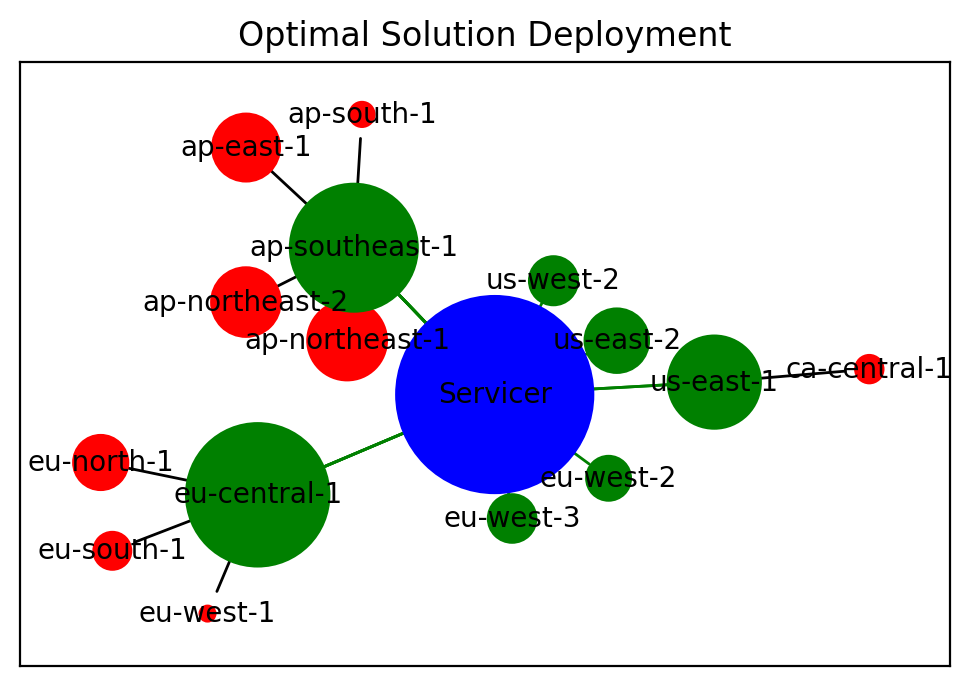

In [54]:
# list of nodes
nodes = []
for i in range(n):
    nodes.append(i)
# summate the number of relays in data
sum = 0
for i in range(n-1):
    sum += data["relays"][i]
# list of node size
node_size = []
service_size = 10000
for i in range(n-1):
    node_size.append(int((data["relays"][i]/sum)*service_size))
node_size.append(service_size*0.5)
# list of node color
node_color = []
for i in range(n-1):
    if y[i].solution_value() == 1:
        node_color.append("green")
    else:
        node_color.append("red")
node_color.append("blue")
# label of nodes i: data["gateway"][i] for i in range(n-1)
labels = {}
for i in range(n-1):
    labels[i] = data["gateway"][i]
labels[n-1] = "Servicer"
# list of edges given solution with arrows
edges = []
for i in range(n-1):
    for j in range(n):
        for k in range(n):
            if x[(i, j, k)].solution_value() == 1:
                edges.append((j, k))
# Edge color
edge_color = []
for i in range(len(edges)):
  # if edge is connected to servicer
  if edges[i][1] == n-1:
    edge_color.append("green")
  else:
    edge_color.append("black")
# Size of arrows
arrowsize = 10

plt.figure(dpi=200)
# draw graph
G = nx.Graph()
# Add nodes
G.add_nodes_from(nodes)
# Add edges
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
#arrow to edge
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_color, 
arrows=True, arrowsize=arrowsize, arrowstyle='-|>')
nx.draw_networkx_labels(G, pos, labels, font_size=10)
plt.title('Optimal Solution Deployment')
plt.show()

# Lets go even further...

At this point it was prouved that the best performance solution is 8 gateways.
Lets see hereafter how the performance is dregraded with < 8 gateways.

Also, what happens if we optimise for WSL instead MLS? (weighted success latency instead median success latency)

Or even, what if the hop time ranges from 25 ms to 100 ms?



In [55]:
def solve_problem(n, maxArcs, M, p, d, c,printSolution=False):
    """
    Solves the problem.
    Args:
        n: number of nodes
        maxArcs: maximum number of arcs
        M: big M
        p: penalty
        d: demand
        c: cost
    Returns:
        x: variable x solution
        y: variable y solution
        solver: solution solver    
    """
    print("Settig problem with n = %i, maxArcs = %i, M = %i, p = %i" % (n, maxArcs, M, p))
    # Create the mip solver with the SCIP backend.
    solver = pywraplp.Solver.CreateSolver("SCIP")
    if not solver:
      raise Exception("Could not create solver")      
    # ----------------------------------------------------------
    # Variables
    # ----------------------------------------------------------
    # x[i, j, k] = 1 if for the route i the arc (j,k) is active.
    # dvar boolean x[1..n][1..n][1..n];
    x = {}
    for i in range(n-1): # route
        for j in range(n): # arc_i
            for k in range(n): # arc_k
                x[(i, j, k)] = solver.IntVar(0, 1, "x_%i_%i_%i" % (i, j, k))

    # dvar boolean y[1..n];
    # # y[j] = 1 if the bin j gateway is connected to servicer
    y = {}
    for j in range(n):
        y[j] = solver.IntVar(0, 1, "y_%i" % j)

    # ----------------------------------------------------------
    # Constraints
    # ----------------------------------------------------------

    # 1)
    # forall (i in 1..n-1) sum(k in 1..n : i!=k) x[i][i][k] - sum(k in 1..n : i!=k) x[i][k][i] == 1;
    for i in range(n-1):
        solver.Add(
          solver.Sum([x[(i, i, k)] for k in range(n) if i != k]) - \
          solver.Sum([x[(i, k, i)] for k in range(n) if i != k]) == 1)
    # 2)
    # forall (i in 1..n-1) sum(k in 1..n-1) x[i][n][k] - sum(k in 1..n-1) x[i][k][n] == -1;
    for i in range(n-1):
        solver.Add(
          solver.Sum([x[(i, n-1, k)] for k in range(n-1)]) - \
          solver.Sum([x[(i, k, n-1)] for k in range(n-1)]) == -1)
    # 3)
    # forall (i in 1..n-1, j in 1..n-1 : i!=j) sum(k in 1..n : j!=k) x[i][j][k] == sum(k in 1..n : j!=k) x[i][k][j];
    for i in range(n-1):
        for j in range(n-1):
            if i != j:
                solver.Add(
                  solver.Sum([x[(i, j, k)] for k in range(n) if j != k]) == \
                  solver.Sum([x[(i, k, j)] for k in range(n) if j != k]))
    # 4)
    # forall (i in 1..n-1, j in 1..n) sum(k in 1..n) x[i][j][k] <= 1;
    for i in range(n-1):
        for j in range(n):
            solver.Add(
              solver.Sum([x[(i, j, k)] for k in range(n)]) <= 1)
    # 5)
    # forall (j in 1..n-1) sum(i in 1..n-1) x[i][j][n] <= M*y[j];
    for j in range(n-1):
        solver.Add(
          solver.Sum([x[(i, j, n-1)] for i in range(n-1)]) <= M*y[j])
    # 6)
    # forall (j in 1..n-1) sum(i in 1..n-1) x[i][j][n] >= y[j];
    for j in range(n-1):
        solver.Add(
          solver.Sum([x[(i, j, n-1)] for i in range(n-1)]) >= y[j])
          
    # 7)
    # sum (j in 1..n-1) y[j] <= maxArcs;
    solver.Add(
      solver.Sum([y[j] for j in range(n-1)]) <= maxArcs)
    # ----------------------------------------------------------
    # Objective:
    # ----------------------------------------------------------
    # z == sum(i in 1..n-1, j in 1..n-1, k in 1..n : j!=k) d[i]*c[j][k]*x[i][j][k] + sum(i in 1..n-1, j in 1..n-1, k in 1..n : j!=k) d[i]*p*x[i][j][k];
    z = solver.Sum(
      solver.Sum(
        solver.Sum(
          d[i]*c[j][k]*x[(i, j, k)] for k in range(n) if j != k) for j in range(n)) for i in range(n-1)) + \
      solver.Sum(
        solver.Sum(
          solver.Sum(
            d[i]*p*x[(i, j, k)] for k in range(n-1) if j != k) for j in range(n)) for i in range(n-1))
    ## Solution
    # solver minimizer
    print("Solving ...")
    solver.Minimize(z)
    # status solver
    status = solver.Solve()
    # print solution
    if printSolution:
        if status == pywraplp.Solver.OPTIMAL:
            print("Solution: OPTIMAL, Time = ", solver.WallTime(), " milliseconds")
            print("Objective value = ", solver.Objective().Value())
            print("Number of variables = ", solver.NumVariables())
            print("Number of constraints = ", solver.NumConstraints())
            print("Number of branch-and-bound nodes explored = ", solver.nodes())
            print("Number of simplex iterations = ", solver.iterations())
            print("Number of branch-and-bound nodes explored = ", solver.nodes())

            for i in range(n-1):
                for j in range(n):
                    for k in range(n):
                        if x[(i, j, k)].solution_value() == 1:
                            print("x[%i][%i][%i] = %i" % (i, j, k, x[(i, j, k)].solution_value()))
    
    return x, y, solver

In [56]:
LATENCY_METRICs = ['median_success_latency', 'weighted_success_latency']
HOP_List = [25, 50, 75, 100]
maxArcs_list = [1,2,3,4,5,6,7]
# Parameters
n = len(data["gateway"]) + 1
M = 300000000000
p = HOP_TIME_MS # hop penalization
sol_dict = dict()
for p in HOP_List:
  sol_dict[p] = {'median_success_latency': list(), 'weighted_success_latency': list()}
  for lat_met_i in LATENCY_METRICs:
      data = create_data(ping_data, columns_ping_data, grouped_df, lat_met_i)
      d = data["relays"]
      c = data["latency"]
      for i_maxArcs in maxArcs_list:
          x, y, solver = solve_problem(n, i_maxArcs, M, p, d, c)
          if lat_met_i == 'median_success_latency':
              sol_dict[p][lat_met_i].append(solver.Objective().Value()/grouped_df['total_success'].sum())
          else:
              sol_dict[p][lat_met_i].append(solver.Objective().Value()/grouped_df['total_success'].sum())

Settig problem with n = 16, maxArcs = 1, M = 300000000000, p = 25
Solving ...
Settig problem with n = 16, maxArcs = 2, M = 300000000000, p = 25
Solving ...
Settig problem with n = 16, maxArcs = 3, M = 300000000000, p = 25
Solving ...
Settig problem with n = 16, maxArcs = 4, M = 300000000000, p = 25
Solving ...
Settig problem with n = 16, maxArcs = 5, M = 300000000000, p = 25
Solving ...
Settig problem with n = 16, maxArcs = 6, M = 300000000000, p = 25
Solving ...
Settig problem with n = 16, maxArcs = 7, M = 300000000000, p = 25
Solving ...
Settig problem with n = 16, maxArcs = 1, M = 300000000000, p = 25
Solving ...
Settig problem with n = 16, maxArcs = 2, M = 300000000000, p = 25
Solving ...
Settig problem with n = 16, maxArcs = 3, M = 300000000000, p = 25
Solving ...
Settig problem with n = 16, maxArcs = 4, M = 300000000000, p = 25
Solving ...
Settig problem with n = 16, maxArcs = 5, M = 300000000000, p = 25
Solving ...
Settig problem with n = 16, maxArcs = 6, M = 300000000000, p = 2

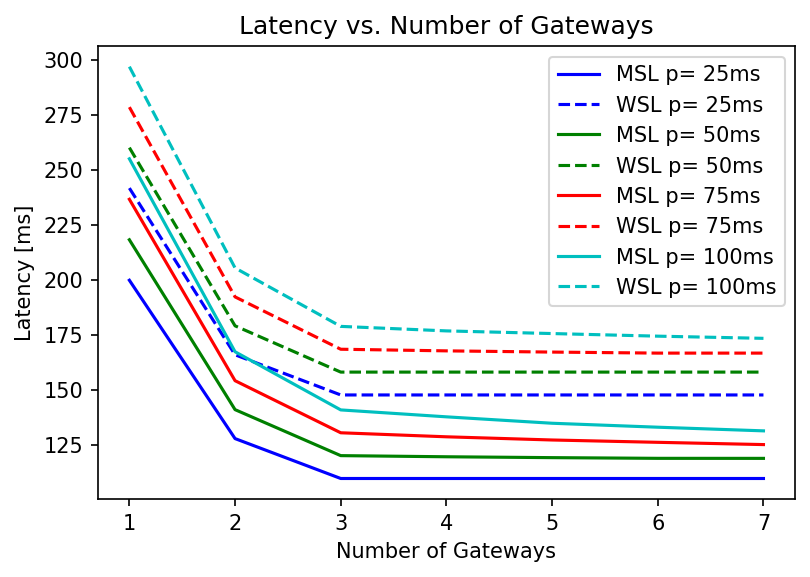

In [57]:
colors = ['b', 'g', 'r', 'c']
plot = plt.figure(dpi=150)
for p, c in zip(HOP_List, colors):
  for lat_met_i in LATENCY_METRICs:
    if lat_met_i == 'median_success_latency':
      plt.plot(maxArcs_list, sol_dict[p][lat_met_i], color=c, label="MSL p= "+str(p) + 'ms' )
    else:
      plt.plot(maxArcs_list, sol_dict[p][lat_met_i], color=c, linestyle='dashed', label="WSL p= "+str(p)+ 'ms' )
plt.legend()
plt.xlabel('Number of Gateways')
plt.ylabel('Latency [ms]')
plt.title('Latency vs. Number of Gateways')
plt.savefig('mean_latency_vs_number_of_gateways.png')
plt.show()